# Биоинформатика. Фабарисов Дмитрий, Брсоян Ваге. 2 курс ШАД.

In [38]:
from yahmm import *
import numpy as np
import copy as cp
import pandas as pd 
import matplotlib as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Функция инициализации модели

In [18]:
def init_model(model_name, starts, transitions, a=0.5):
    Distrib_1 = yahmm.DiscreteDistribution({'1':1./6,'2':1./6,'3':1./6,'4':1./6,'5':1./6,'6':1./6})
    Distrib_2 = yahmm.DiscreteDistribution({'1':a,'2':(1-a)/5,'3':(1-a)/5,'4':(1-a)/5,'5':(1-a)/5, '6':(1-a)/5})

    state1 = yahmm.State(Distrib_1, name="state_1")
    state2 = yahmm.State(Distrib_2, name="state_2")
    model = yahmm.Model(name=model_name)
    # Определяем состояния
    model.add_state(state1)
    model.add_state(state2)

    # Начальные вероятности
    model.add_transition(model.start, state1, starts[0])
    model.add_transition(model.start, state2, starts[0])

    # Задаем матрицу переходов
    model.add_transition(state1, state1, transitions[0][0])
    model.add_transition(state1, state2, transitions[0][1])
    model.add_transition(state2, state1, transitions[1][0])
    model.add_transition(state2, state2, transitions[1][1])
    
    model.bake()
    return model

## Функция тестирования модели

Генерируем 100 элементные последовательности.  
Для обучающей выборки их число меняется, для тестовой всегда 200.  
Для теста считаем ошибку Forward-Backward и Viterbi из библиотеки yahmm.

In [41]:
def test_model(model, filename):
    f = open(filename, 'w')
    size = 100
    for train_len in range(1, 100, 5):

        # Тестовая выборка
        count = 200
        test = [model.sample(size, 1) for i in range(count)]
        test_st = [[1 * (test[i][1][j] == state2) for j in range(1, size+1)] for i in range(count)]
        test = [test[i][0] for i in range(count)]

        # Обучающая выборка и обучение
        count = train_len
        train = [model.sample(size) for i in range(count)]
        model_1 = model
        model_1.train(train)

        # Forward-Backward
        err = 0
        for j in range(count):
            pred = model_1.forward_backward(test[j])[1]
            st = [1 * (pred[i][0] < pred[i][1]) for i in range(size)]
            diff = sum(abs(np.array(st) - np.array(test_st[j])))
            err += min(diff, len(st) - diff) * 1.0 / size
            
        err = err / count
        print err

        # Viterbi
        err1 = 0
        for j in range(count):
            vit_res = model_1.viterbi(test[0])[1][1:]
            st = [i[0] for i in vit_res]
            diff = sum(abs(np.array(st) - np.array(test_st[j])))
            err1 += min(diff, len(st) - diff) * 1.0 / size
        
        err1 = err1 / count
        print err1

        f.write(str(train_len))
        f.write(',')
        f.write(str(err))
        f.write(',')
        f.write(str(err1))
        f.write('\n')

    f.close()


## Различные модели

В качестве модели для игральных костей берем равновероятное начальное состояние (не отдаем предпочтения, какая у нас кость (честная, нечестная) в начале). Далее задаем различные модели

Модель 1: переход в другое состояние с вероятностью 0.1, $a = 0.5$  
Модель 2: из первого во второе 0.4, из второго в первое 0.1, $a = 0.5$  
Модель 3: переход в другое состояние с вероятностью 0.1, $a = 0.9$  
Модель 4:из первого во второе 0.4, из второго в первое 0.1, $a = 0.1$ 

In [54]:
model_1 = init_model("Mod1", [0.5, 0.5], [[0.9, 0.1], [0.1, 0.9]])
model_2 = init_model("Mod1", [0.5, 0.5], [[0.6, 0.4], [0.1, 0.9]])

model_3 = init_model("Mod1", [0.5, 0.5], [[0.9, 0.1], [0.1, 0.9]], 0.9)
model_4 = init_model("Mod1", [0.5, 0.5], [[0.6, 0.4], [0.1, 0.9]], 0.9)

Запускаем тесты

In [ ]:
test_model(model_1, "res1.csv")
test_model(model_2, "res2.csv")
test_model(model_3, "res3.csv")
test_model(model_4, "res4.csv")

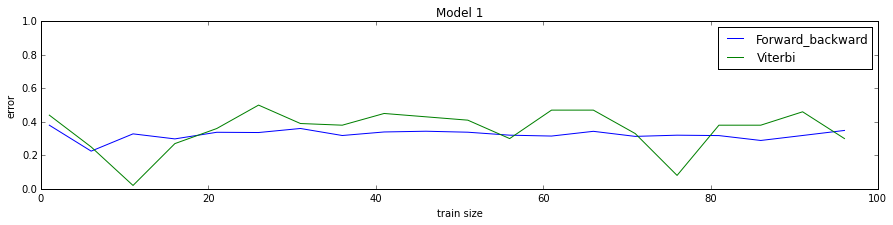

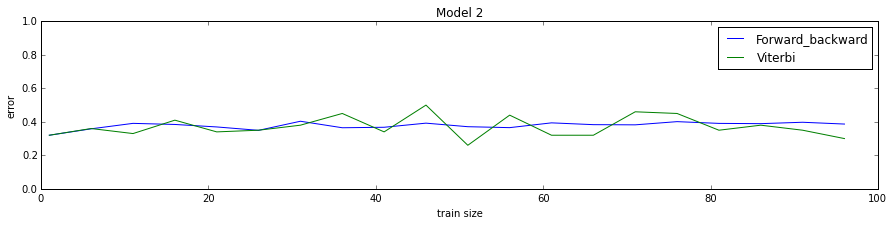

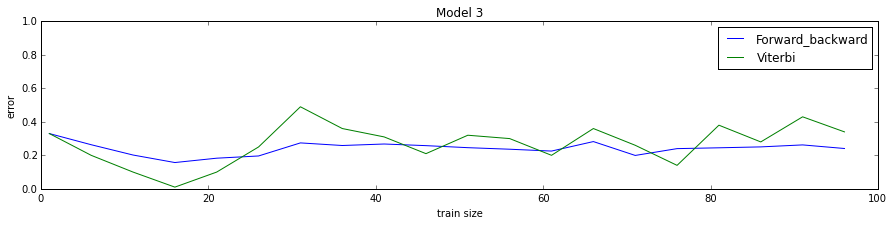

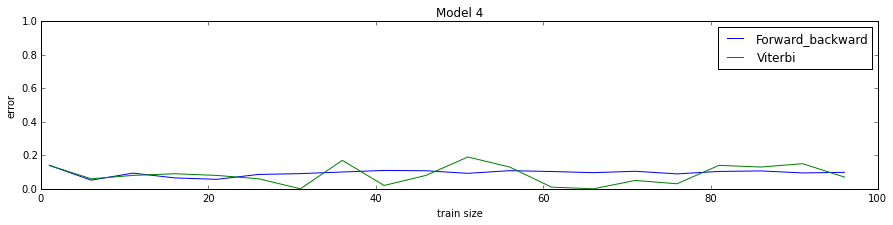

In [56]:
res_1 = pd.read_csv("res1.csv", header=None)
res_2 = pd.read_csv("res2.csv", header=None)
res_3 = pd.read_csv("res3.csv", header=None)
res_4 = pd.read_csv("res4.csv", header=None)
res=[res_1, res_2, res_3, res_4]

model_1="Model 1"
model_2="Model 2"
model_3="Model 3"
model_4="Model 4"

models = [model_1, model_2, model_3, model_4]

for i in range(4):
    plt.figure(figsize=(15, 3))
    plt.title(models[i])
    plt.xlabel("train size")
    plt.ylabel("error")
    plt.ylim(0.0, 1.0)
    plt.plot(res[i][0], res[i][1], label="Forward_backward")
    plt.plot(res[i][0], res[i][2], label="Viterbi")
    plt.legend(loc='best')


Оба алгоритма показывают досточно хороший результат. Viterbi почти не зависит от размера обучающей выборки, в то время как Forward_backward требует определенного размера для обучения, при дальнейшем увеличении выборки результат не меняется